# Single Model Assisted Sensitivity Analysis
This notebook focuses on answering the question: how can AutoMATES leverage the information extracted from source code and free text to improve modelers ability to visualize input sensitivity in a single model?

In this notebook we will demonstrate AutoMATES ability to analyze the Priestley Taylor model of Evapo-transpiration from the DSSAT codebase.

## Visualization goals
- Show that S1 analysis over the whole range of all variables demonstrates a high S1 value for TMAX
- Show that we can use static program analysis to determine that TMAX controls a piecewise function
- Show that we can use evidence from TR when breaking up the bound range of TMAX to reflect the piecewise nature of the function
- Show the updated S1/S2 plots for the broken down ranges

In [3]:
from penman import SensitivityModel
from model_analysis.visualization import SensitivityVisualizer

##### List of Sample Sizes #####

sample_list = [10**x for x in range(1, 6)]


# Setting some constants for the model to use and SA method to deploy
method = 'Sobol'
model = 'PETPT'

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


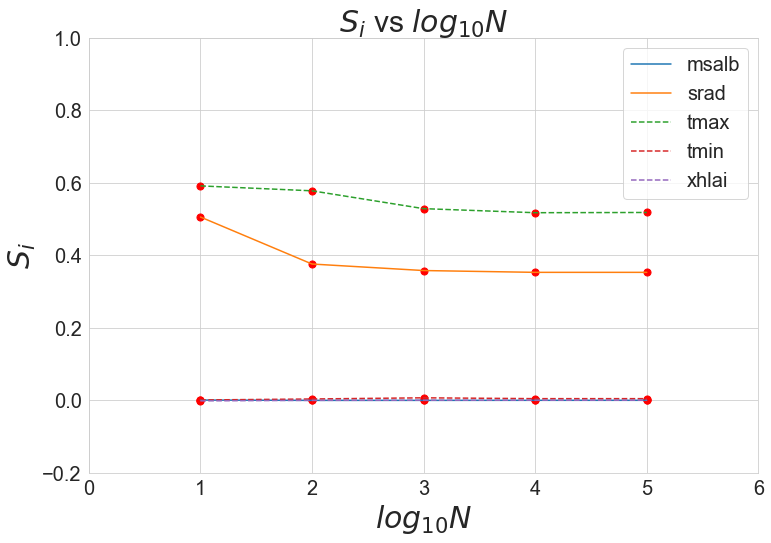

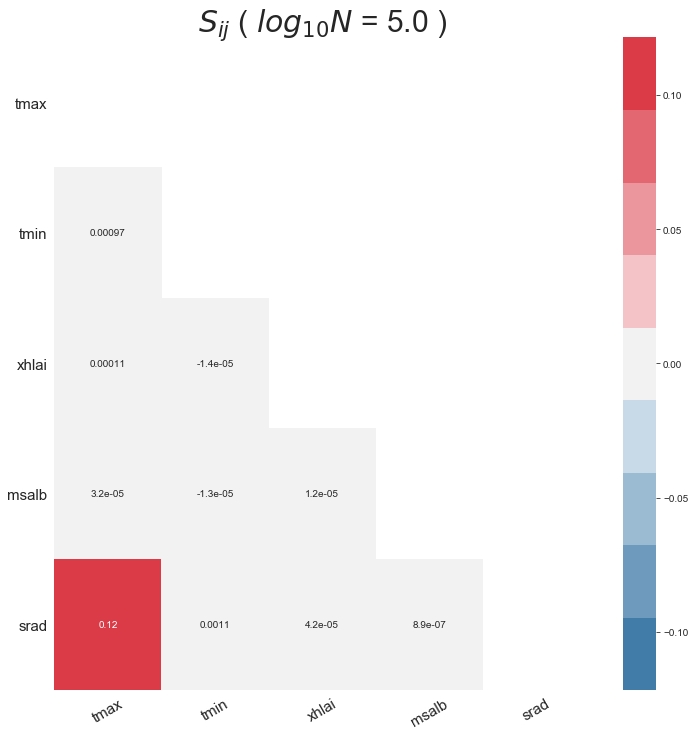

In [4]:
# Using the full-range bounds at first
bounds = {
        'tmax':[-10.0, 50.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPT_S1, df_PETPT_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

component = 'S1'
SM.sensitivity_plots(indices_lst, component)
component = 'S2'
SM.sensitivity_plots(indices_lst, component)

### Analysis of the above results
As we can see from the S1 plot abovwe, it appears that TMAX and SRAD play critical roles in determining the uncertainty of the output here. We can inspect the source code using AutoMATES to try and determine why these two variables play such a significant role. Below is a code-block from the PETPT Fortran source code:
```fortran
      SLANG = SRAD*23.923
      EEQ = SLANG*(2.04E-4-1.83E-4*ALBEDO)*(TD+29.0)
      EO = EEQ*1.1

      IF (TMAX .GT. 35.0) THEN
        EO = EEQ*((TMAX-35.0)*0.05+1.1)
      ELSE IF (TMAX .LT. 5.0) THEN
        EO = EEQ*0.01*EXP(0.18*(TMAX+20.0))
      ENDIF

      EO = MAX(EO,0.0001)
```
In this code-block we can see that TMAX plays a critical role at the end of the PETPT function. This role is to divide the function into three piecewise components based upon the value of TMAX. AutoMATES can detect this using static code analysis on the conditional variables included in the model code.

Using this along with text-reading knowledge of the parameter bounds for TMAX, we can divide the total range of values for TMAX into three separate bound ranges that we can use for further analysis:
1. -10.0ºC -- 5.0ºC
2. 5.0ºC -- 35.0ºC
3. 35.0ºC -- 55.0ºC

Below we show the S1/S2 results for these three different bound ranges.

### Result set 1
Notice for this first result set that we are working with non-extreme values of TMAX. When the values for TMAX are no longer extreme, we see that it drops off significantly from the S1 indices and allows other variables to show how much more of an important role they play in determining model output.

#### Key insights
- SRAD now dominates all other uncertainty sources in the S1 indices
- The interaction between SRAD and TMAX is now shown to be an important S2 index

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


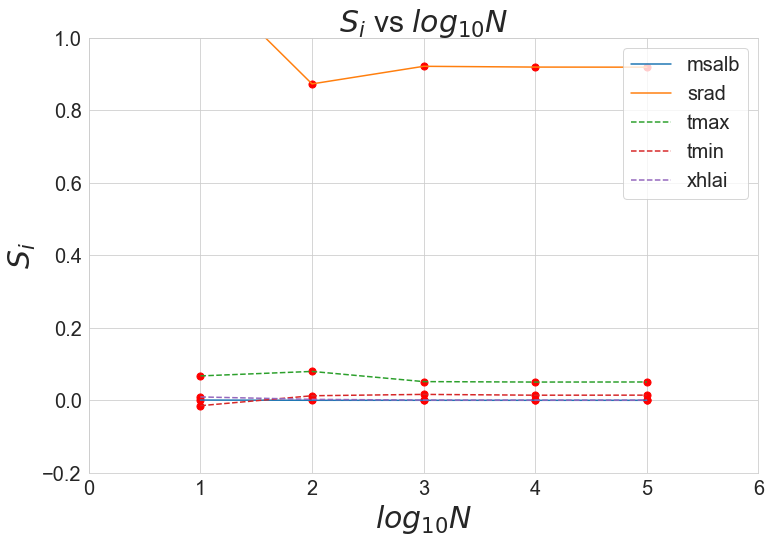

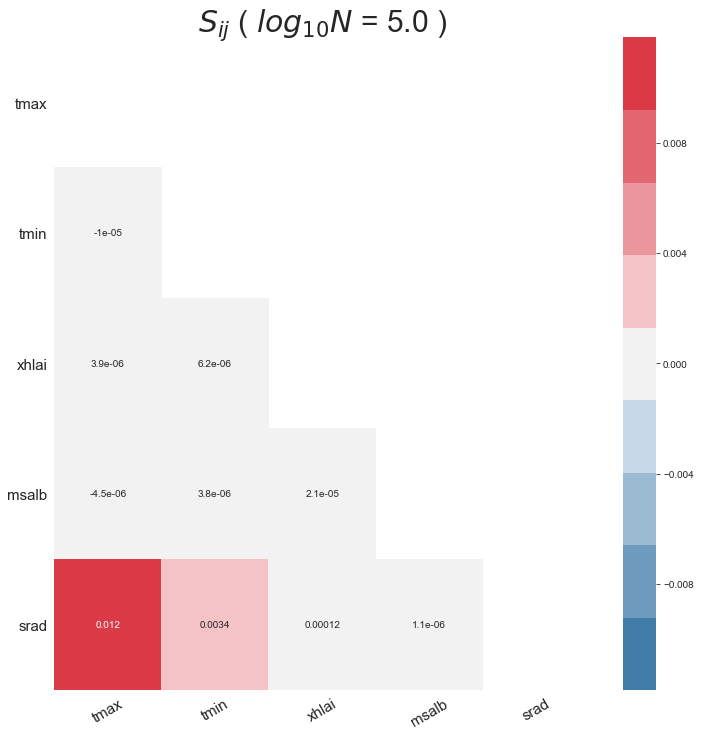

In [5]:
# Choosing the bound set
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)
df_PETPT_S1, df_PETPT_ST = SM.generate_dataframe()
indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result set 2
For this result set we are looking at the extreme lower end of values for TMAX. Here we see that TMAX is an even greater contributor to S1 sensitivity than over the whole range. This is likely due to the scaling of EO done by an exponential term involving TMAX in this portion of the piecewise function.

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


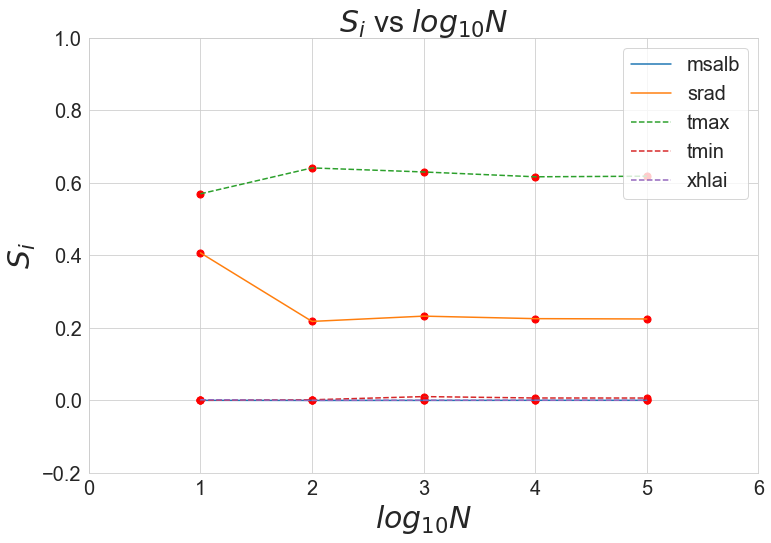

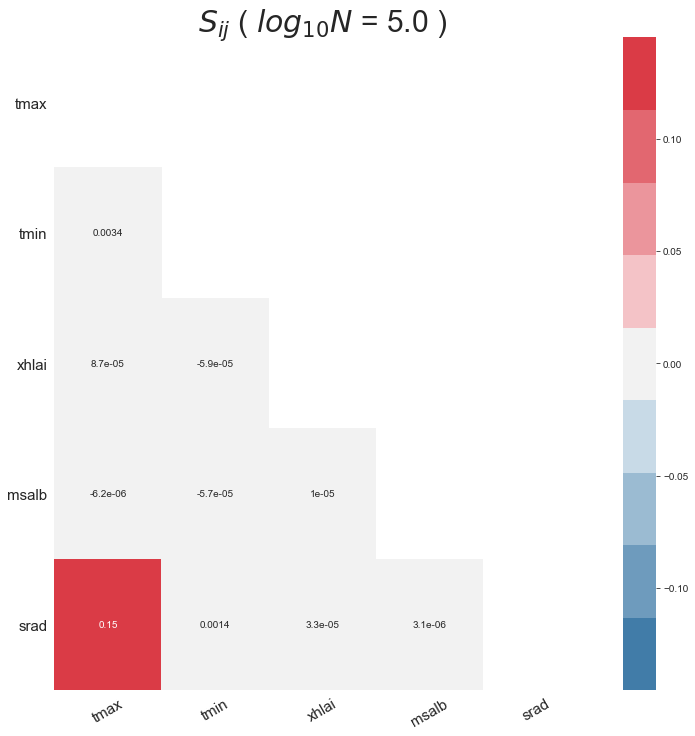

In [6]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPT_S1, df_PETPT_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result set 3
Here we are testing the extreme high end of values for TMAX. For this bound range we are now observing:
- SRAD is the largest contributor to the S1 sensitivity
- TMAX is still a large contributor to the S1 sensitivity
- The total S1 sensitivity has increased dramatically, causing a large decrease in S2 total sensitivity which lowers the impact of the TMAX/SRAD interaction term. This is likely due to the scaling of EO by TMAX in this branch of the piecewise function

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


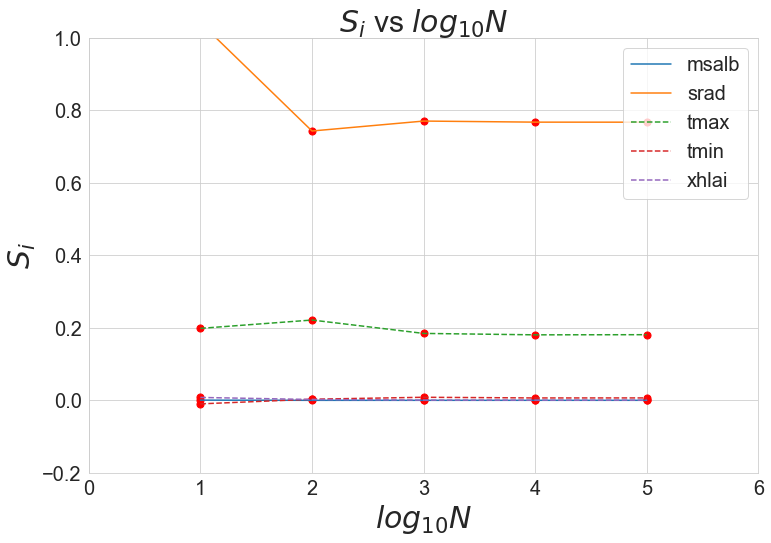

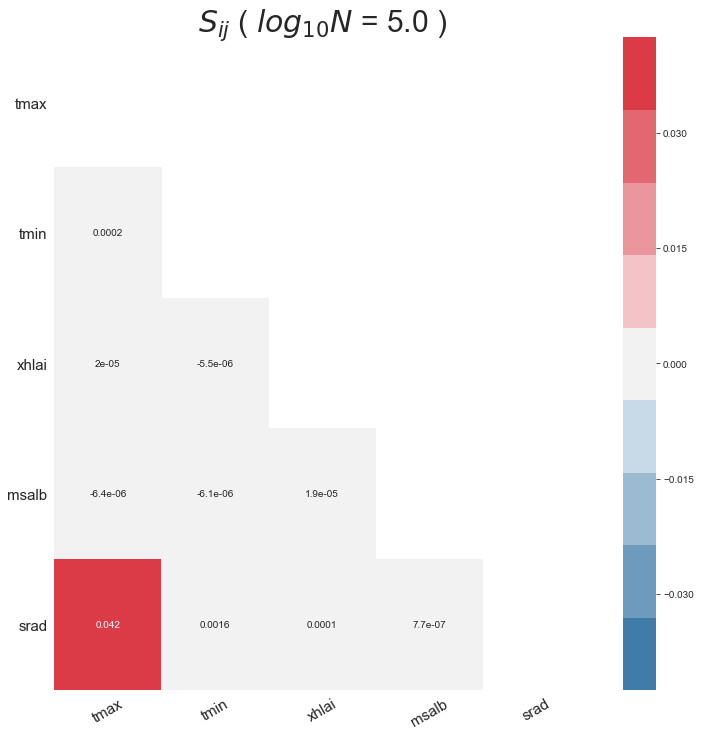

In [7]:
bounds = {
        'tmax':[35.01, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPT_S1, df_PETPT_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

component = 'S1'
SM.sensitivity_plots(indices_lst, component)
component = 'S2'
SM.sensitivity_plots(indices_lst, component)

## Take-home Message
In this demo we have shown how an initial sensitivity analysis of a scientific model can inform which variables to search for when doing single-variable range analysis. AutoMATES enables us to search the source code of the model automatically to determine where in the code variables with high S1 sensitivites cause functional differences. Using the parameter estimation from the TR component of AutoMATES and static progam analysis from the PA component of AutoMATES we can then perform a second set of sensitivty analysis upon a broken up range of the variable in question. This allows AutoMATES to deliver deeper insights about the sensitivity of a scientific model to its inputs without requiring a modeler to:
- manualy trek through the model code searching for the variable interactions of highest interest
- find correct bound parameters for variables of interest in the literature
- create new sensitivity analysis experiments as appropriate for the new ranges of a variable of interest

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


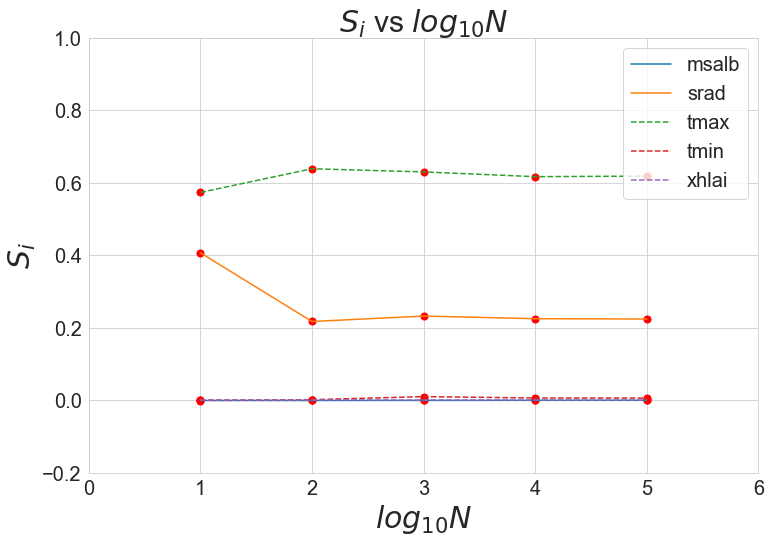

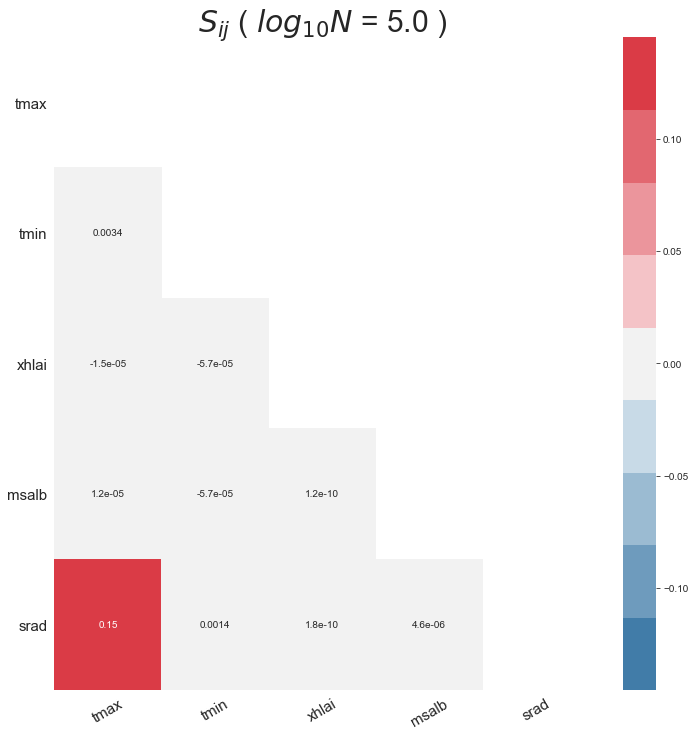

In [9]:
# Choosing the bound set
bounds = {
        'tmax':[-10.0, 5.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [-0.00001, 0.00001]
    }

SM = SensitivityModel(model, bounds, sample_list, method)
df_PETPT_S1, df_PETPT_ST = SM.generate_dataframe()
indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

# Multi-Model Analysis : Penaman-Monteith Based Models (PETPNO, PETPEN, PETDYN)

## PETPNO

### Result Set 1 - TMAX  : (5.0, 35.0)

- SRAD still has the highest S1 index
- TMAX, TMIN, TDEW, CLOUDS all have moderately strong indices
- (TMAX, SRAD), (TDEW, SRAD) have S2 indices above 0.01 cut-off

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


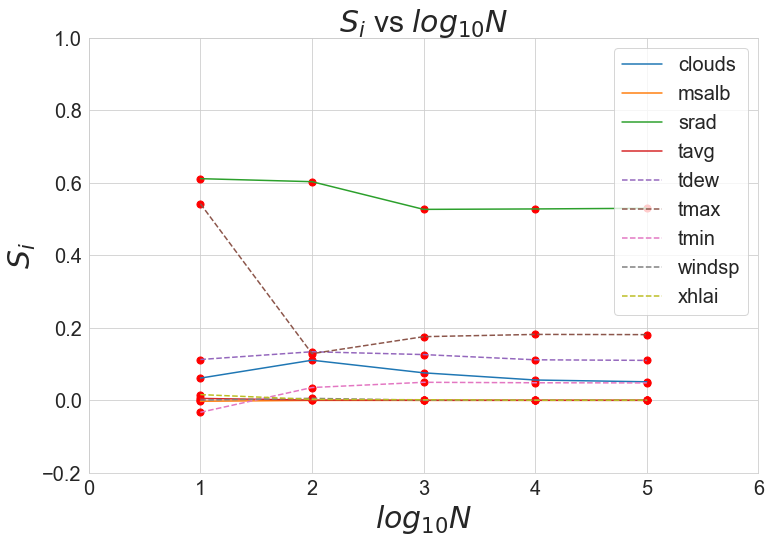

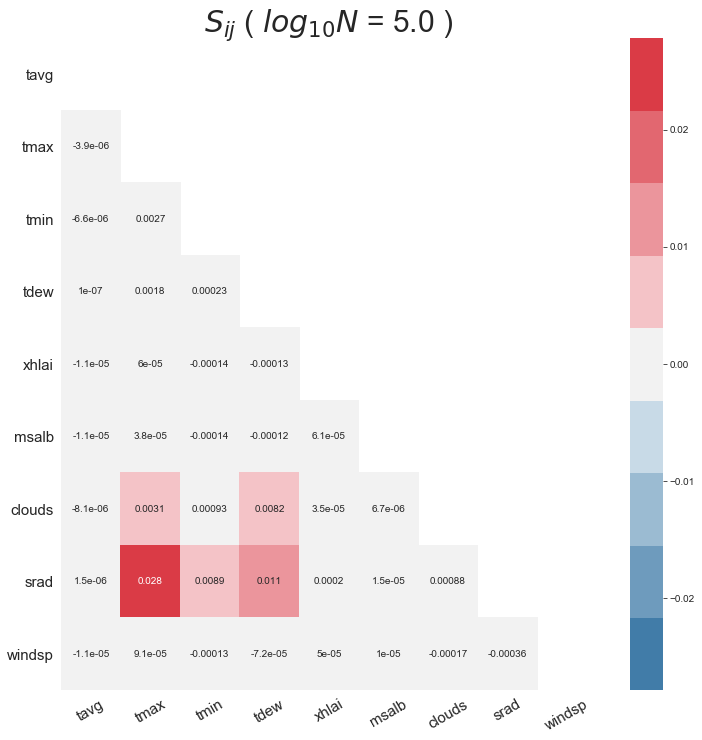

In [37]:
model = 'PETPNO'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPNO_S1, df_PETPNO_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2  -  TMAX : (-10.0, 4.99)

- SRAD still has the largest S1 index but lower than in the previous case
- TMAX, TMIN have large S1 indices
- (TMIN, SRAD), (TDEW, SRAD) S2 indices have increased significantly

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


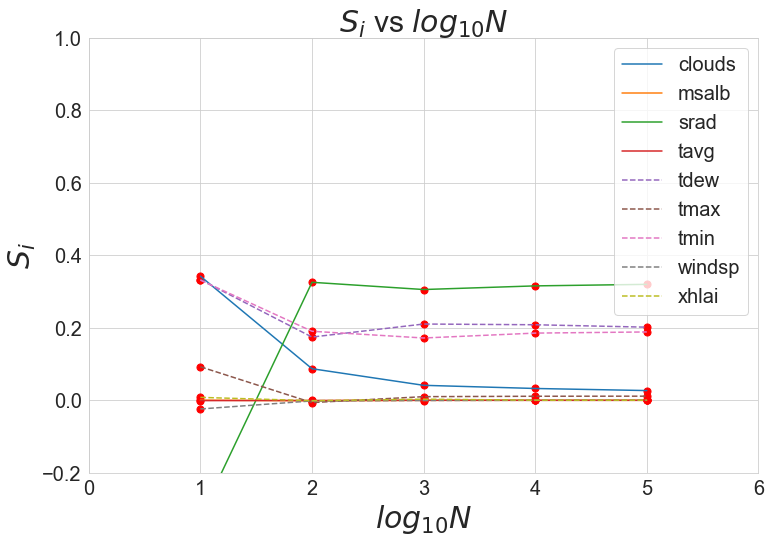

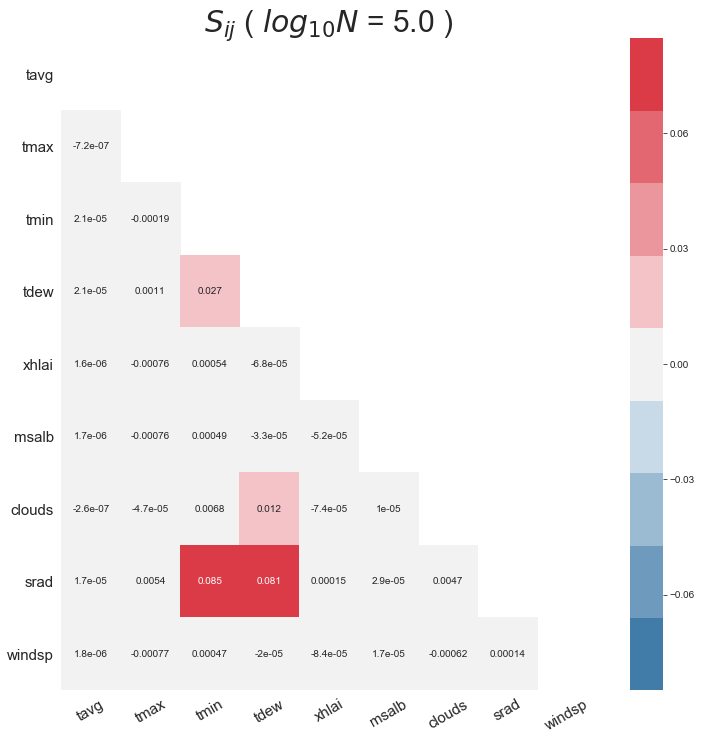

In [12]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPNO_S1, df_PETPNO_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3 - TMAX : (35.1, 55.0)

- SRAD has maximum S1 and close to 1.0 signifying that the majority of contribution to sensitivity stems from this parameter 

- CLOUDS, TMAX has moderately strong S1 index

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


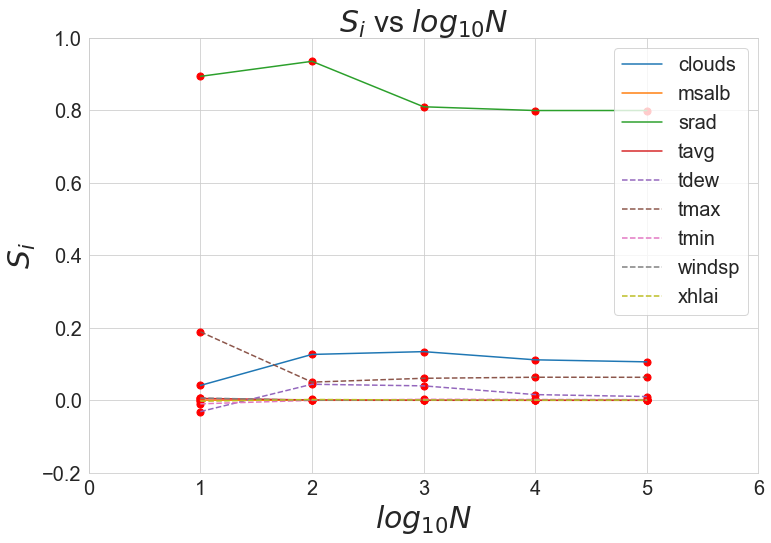

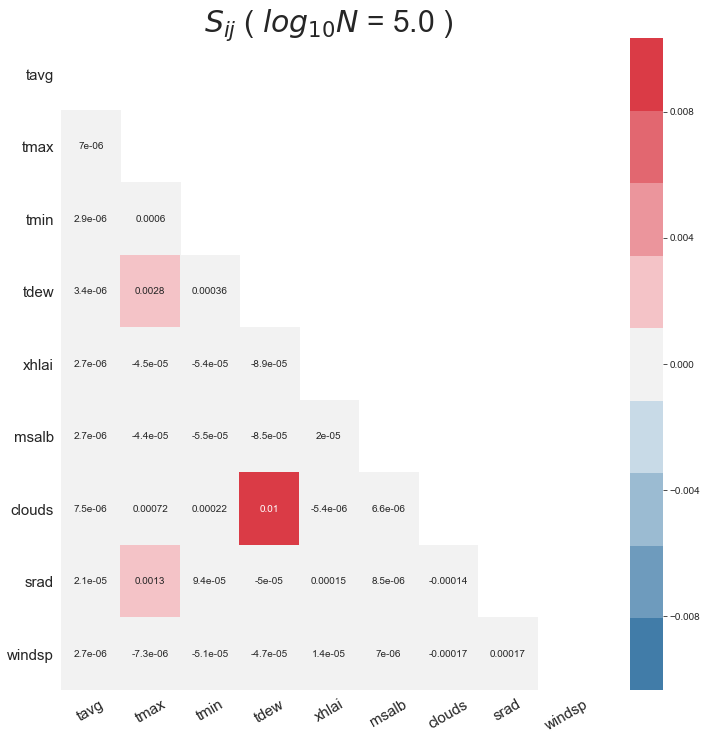

In [14]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPNO_S1, df_PETPNO_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### XHLAI : (-0.001, 0.001) ; TMAX : (5.0, 35.0)

There exists a conditional (shown below) in PETPNO which alters the function of EO. We take negative values of XHLAI to probe whether it affects the analysis. TMAX values have been taken from Result Set 1

- No significant change is observed

``` fortran
      IF (XHLAI .LE. 0.0) THEN
        ALBEDO = MSALB
      ELSE
        ALBEDO = 0.23-(0.23-MSALB)*EXP(-0.75*XHLAI)
      ENDIF

```

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


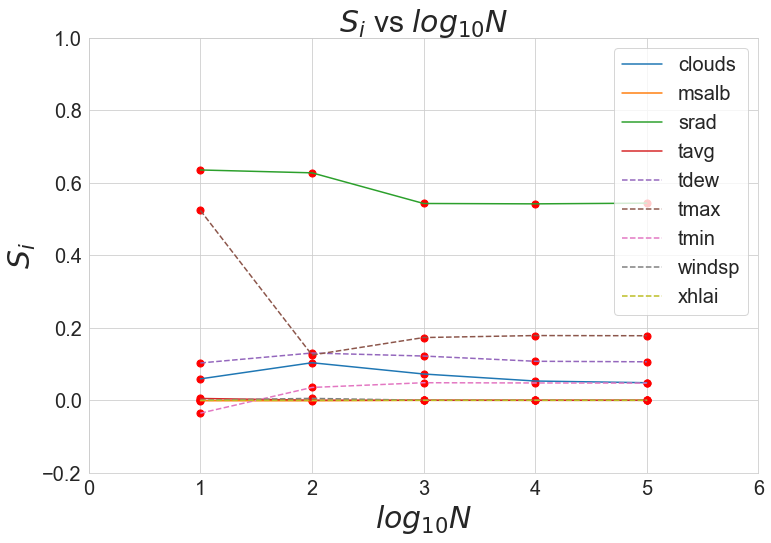

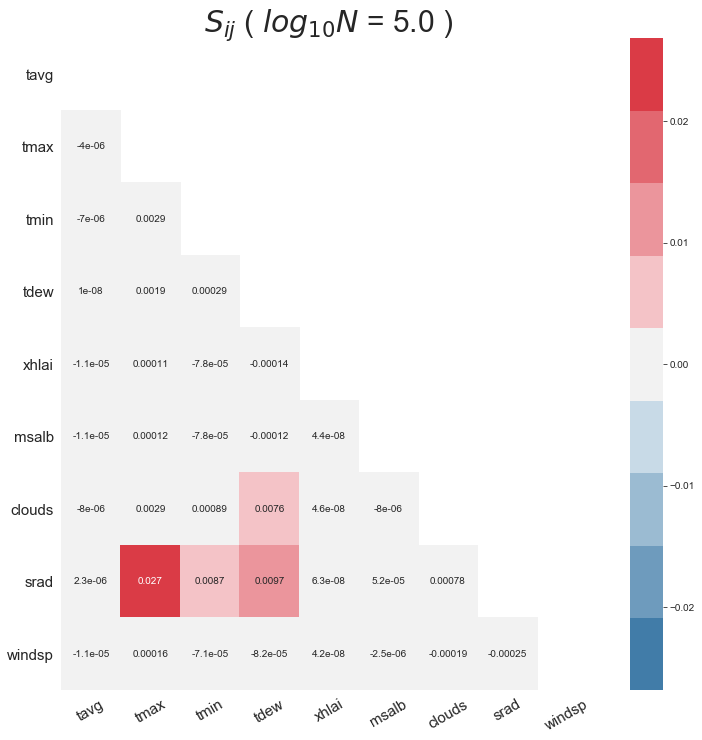

In [19]:

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [-0.001, 0.001],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPNO_S1, df_PETPNO_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD : (0, 5);  TMAX : (5.0, 35.0)

Severely restricting the range of SRAD changes the S1 vs log(N) profile appreciably. This is interesting since the only place SRAD appears in the code is here :
```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
```

What it simply tells us is that the extent to which SRAD can contribute to the variance in the output depends enormously on its bounds.

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


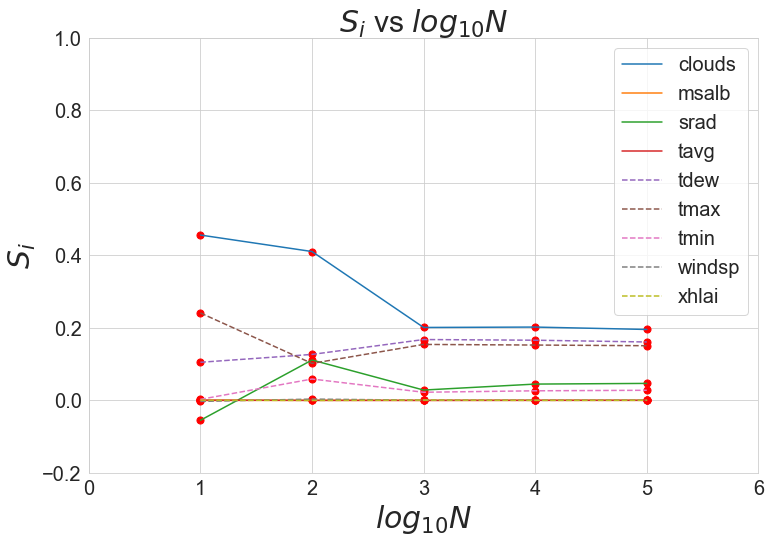

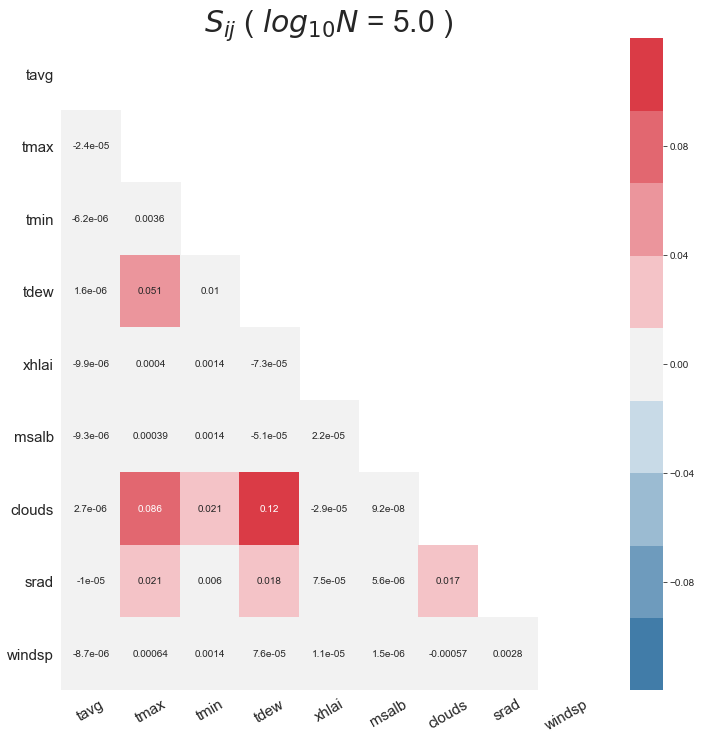

In [21]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPNO_S1, df_PETPNO_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## PETPEN 

### Result Set 1  -  TMAX : (5.0, 35.0)

- SRAD yet again has the highest S1 index
- EORATIO has a large S1 index unqiue to PETPEN
- (VAPR, CLOUDS), (EORATIO, XHLAI), (EORATIO, SRAD) have significant S2 indices 

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


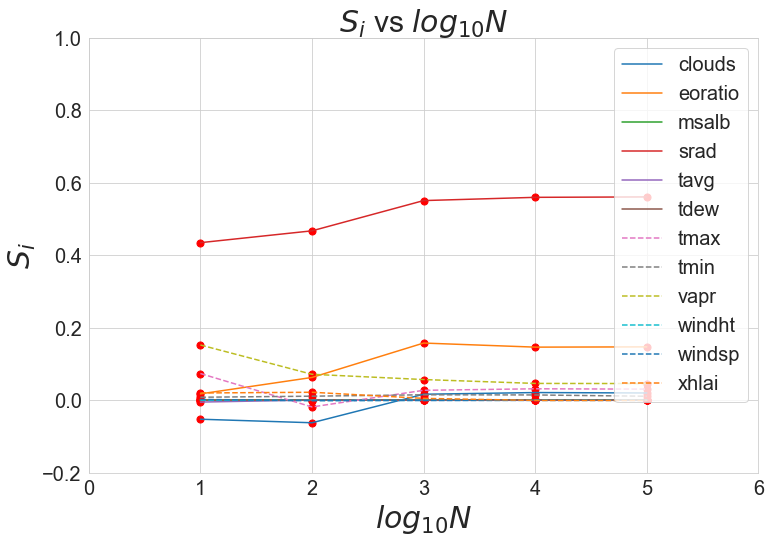

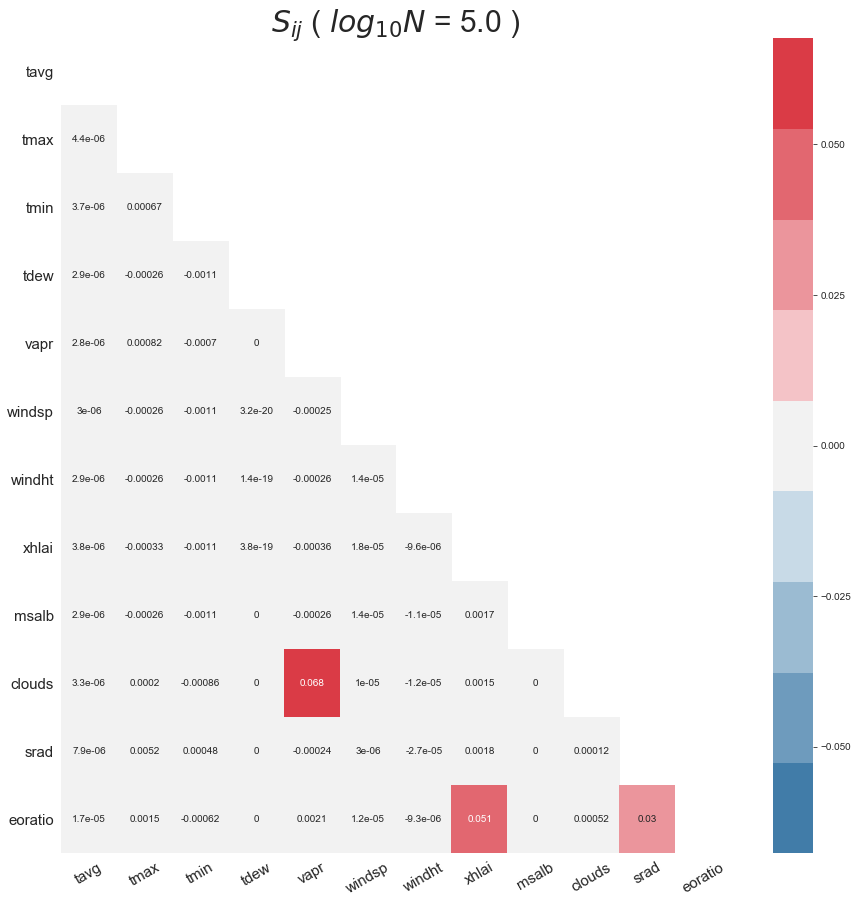

In [34]:
model = 'PETPEN'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPEN_S1, df_PETPEN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2  -  TMAX : (-10.0,  4.99)

- SRAD still has the highest S1 index
- S2 values of relevant pairs are similar

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


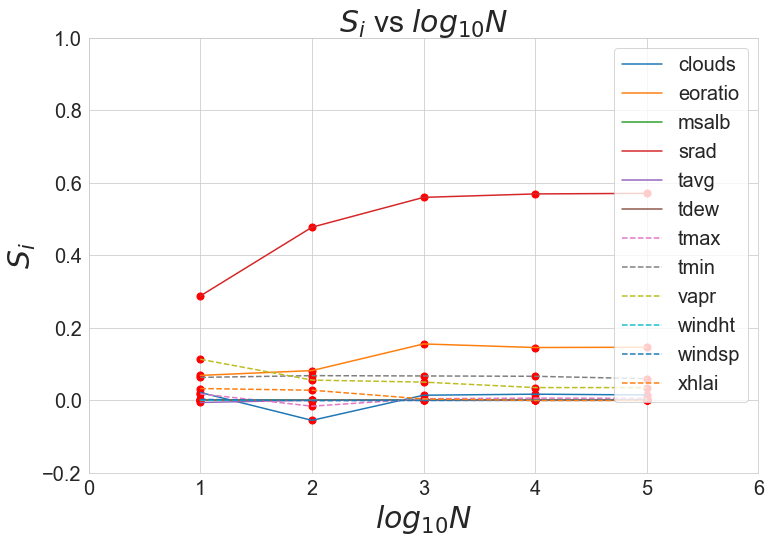

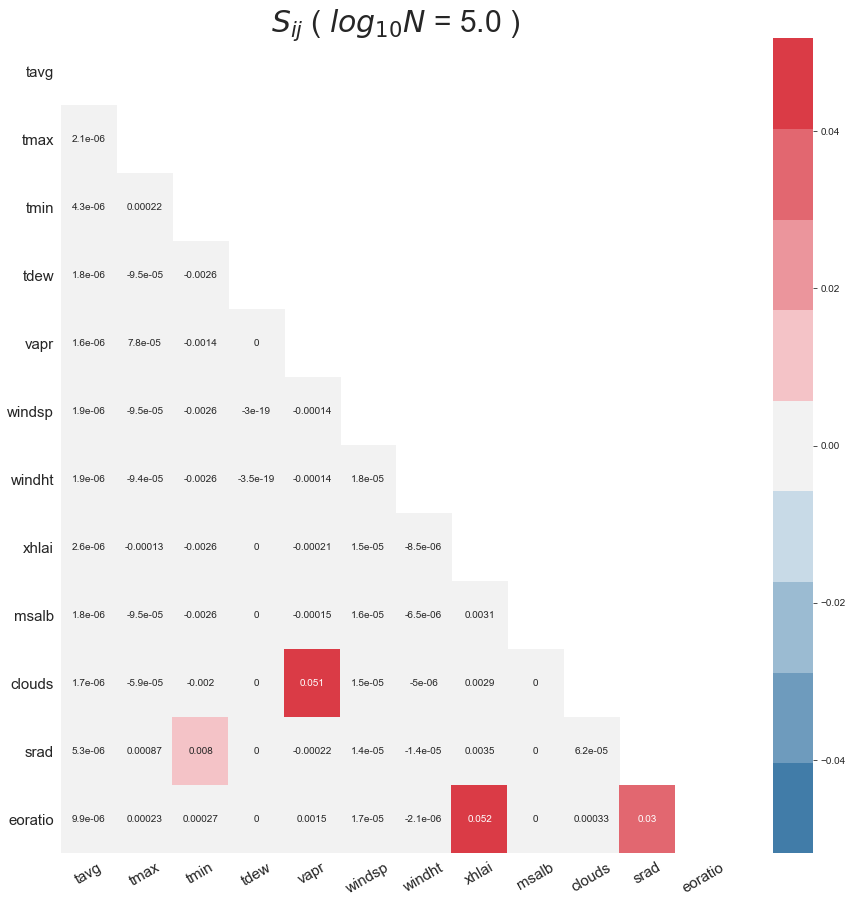

In [23]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPEN_S1, df_PETPEN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3  -  TMAX : (35.1,  55.0)

-  SRAD has the highest S1
- Trend in S2 does not appear to change appreciably

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


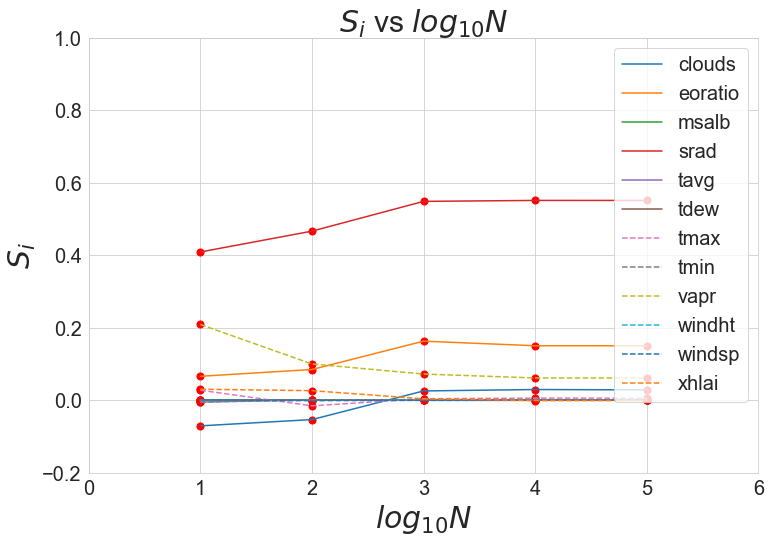

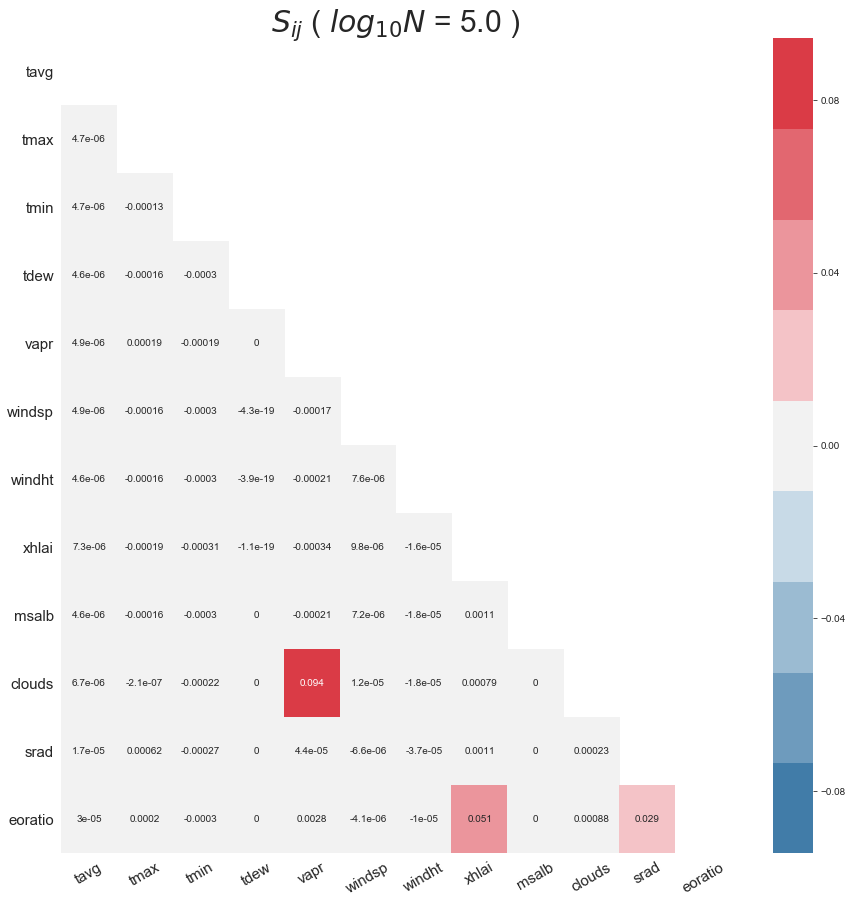

In [25]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPEN_S1, df_PETPEN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD:  (0,  5.0) ; TMAX : (5.0, 35.0)

-  Changing the interval range of SRAD dramatically alters the Sobol index ranking. S1 contribution from SRAD is decreased significantly.

-  Again, if one looks at the PETPEN Fortran code, SRAD appears in the assignment of RNET as seen in PETPNO

```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
```

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


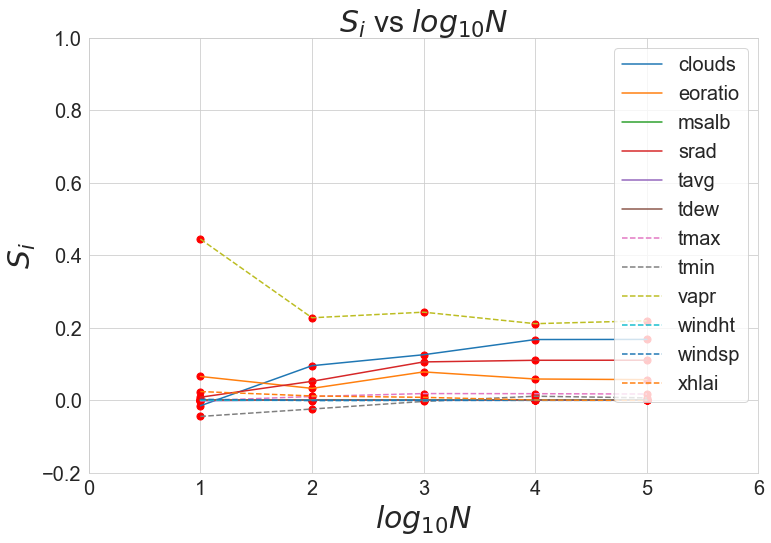

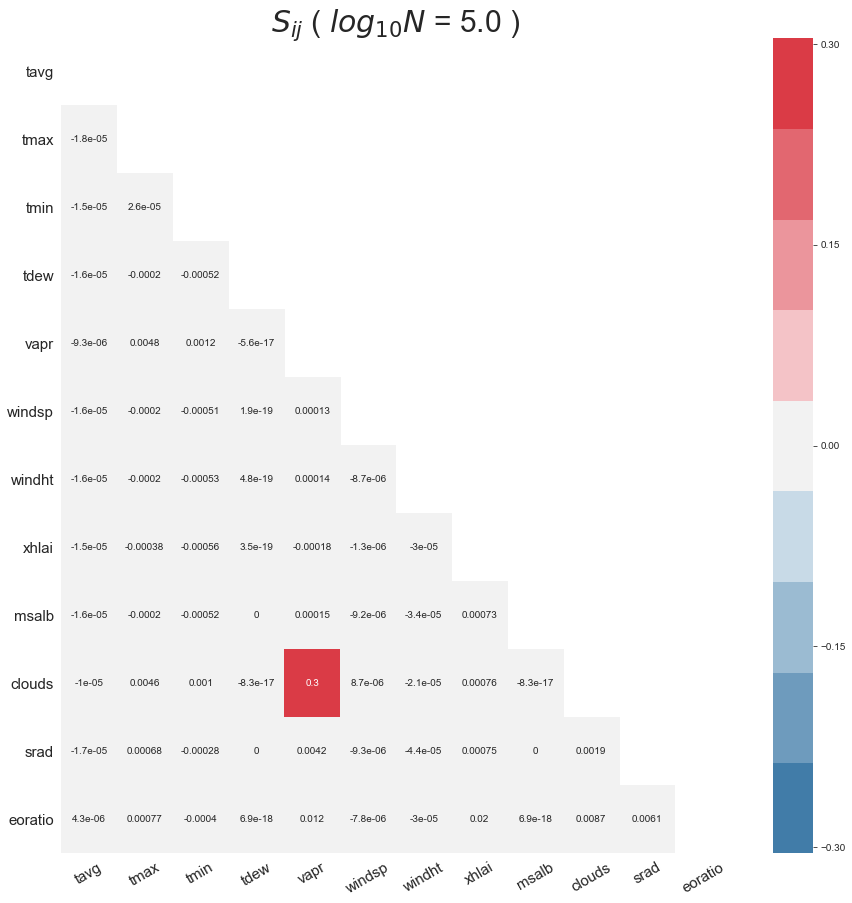

In [31]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

df_PETPEN_S1, df_PETPEN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## PETDYN

### Result Set 1 - TMAX : (5.0,  35.0)

-  SRAD has an overwhelming contribution to the overall variance

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


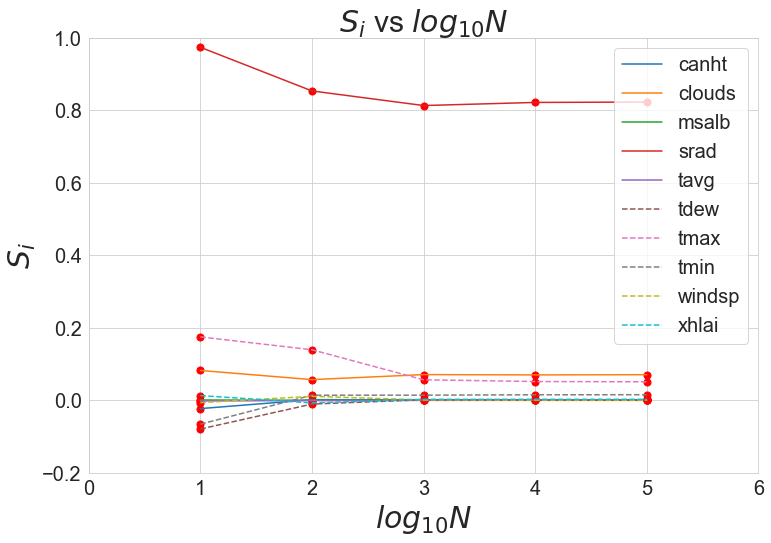

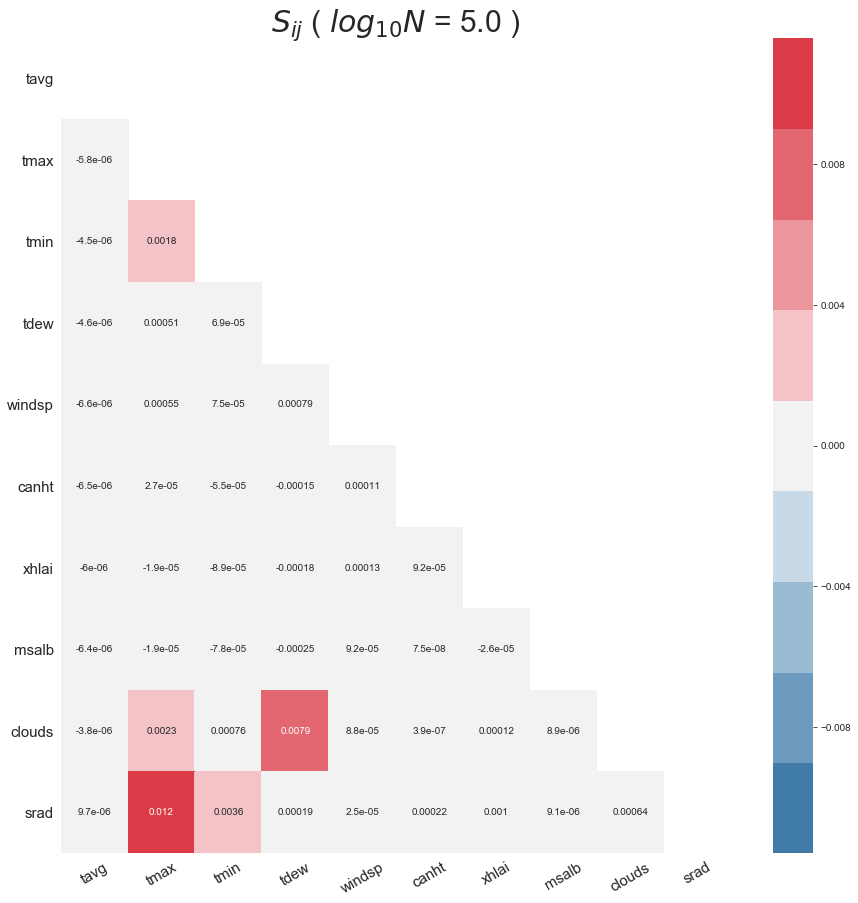

In [33]:
model = 'PETDYN'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETDYN_S1, df_PETDYN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2 - TMAX : (-10.0,  4.99)

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


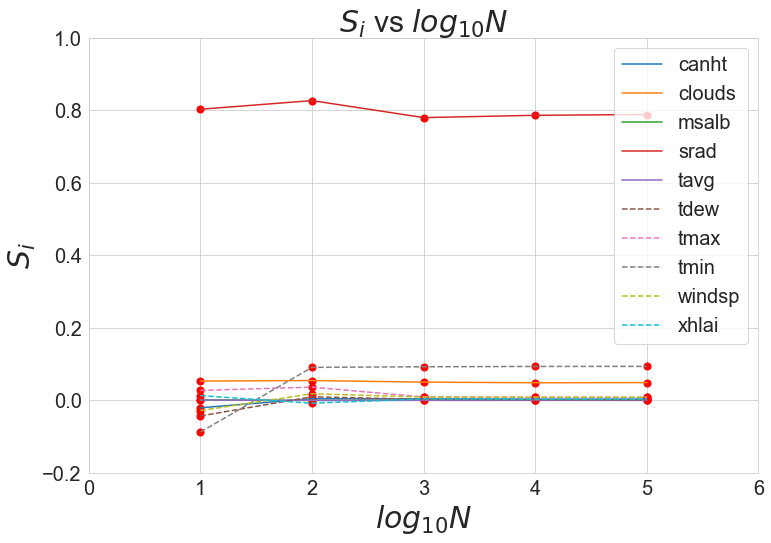

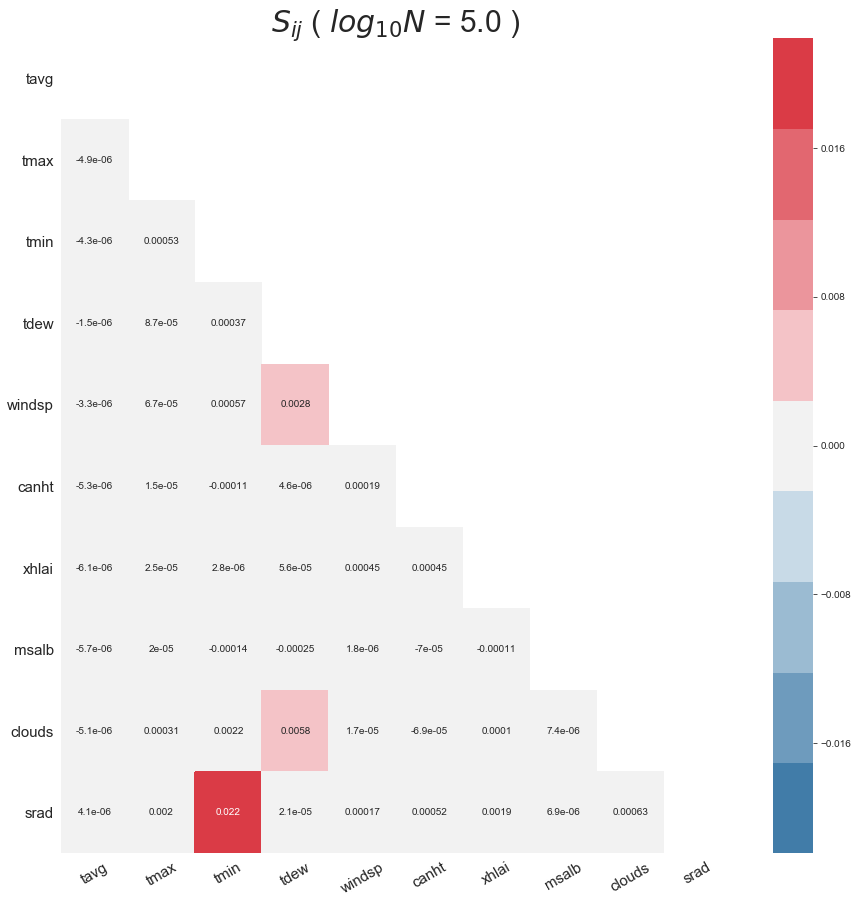

In [28]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETDYN_S1, df_PETDYN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3 - TMAX : (35.1,  55.0)

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


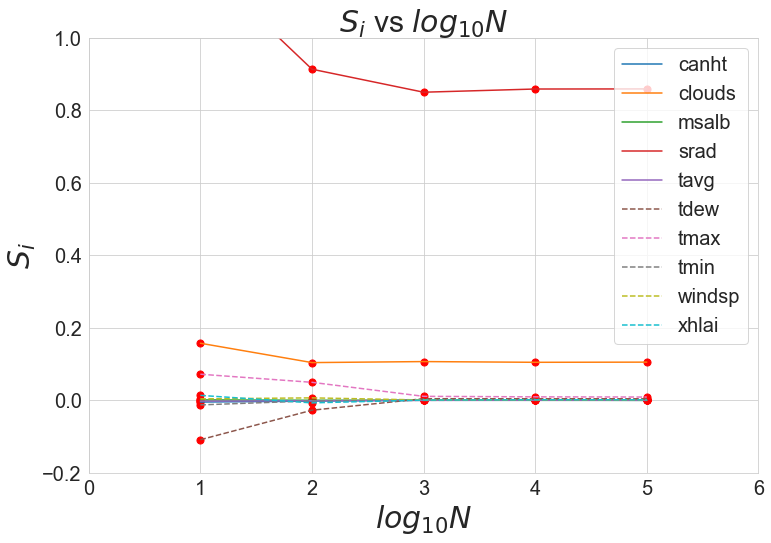

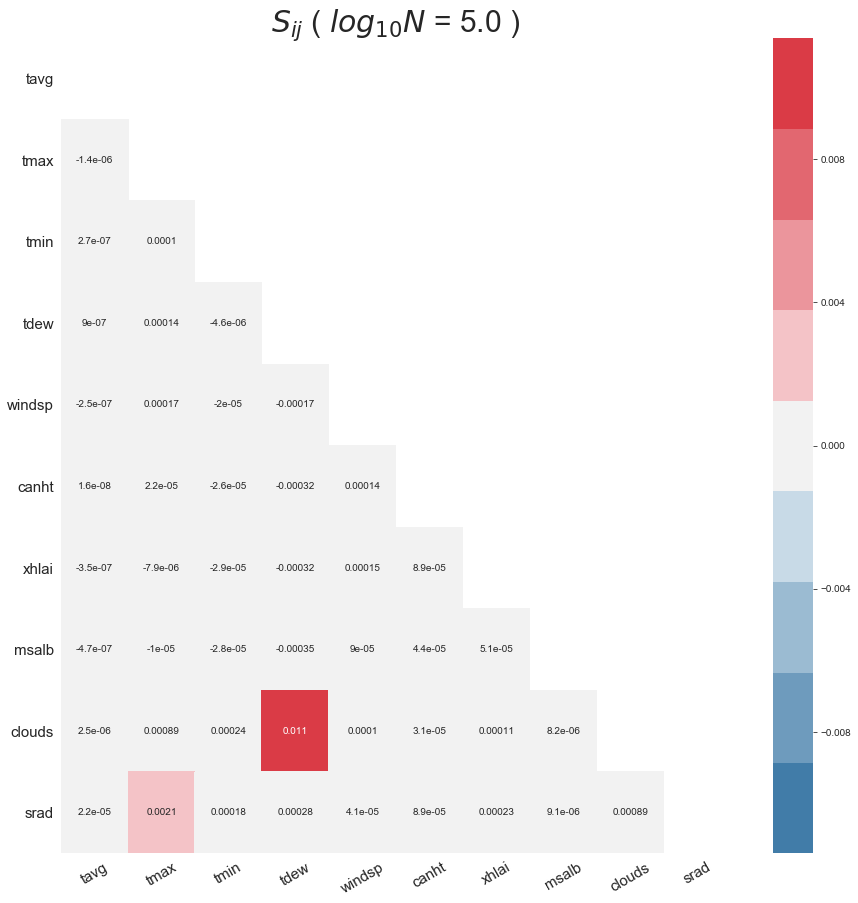

In [29]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETDYN_S1, df_PETDYN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD : (0, 5) ; TMAX : (5.0, 35.0)

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


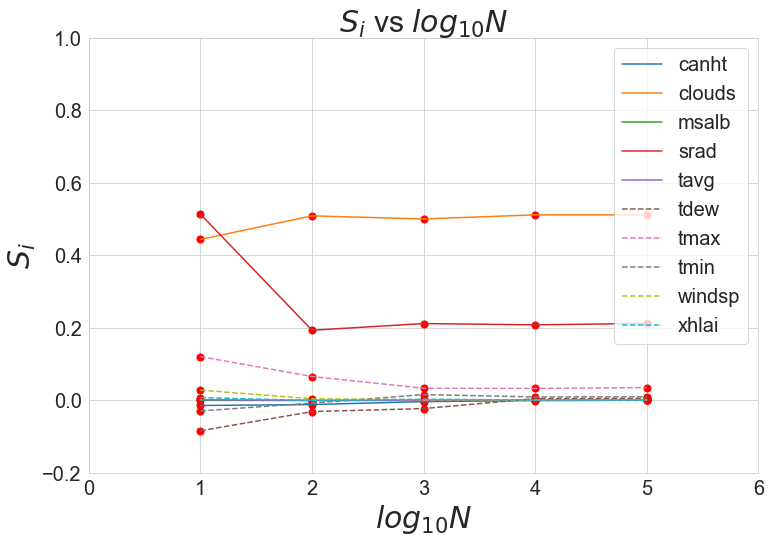

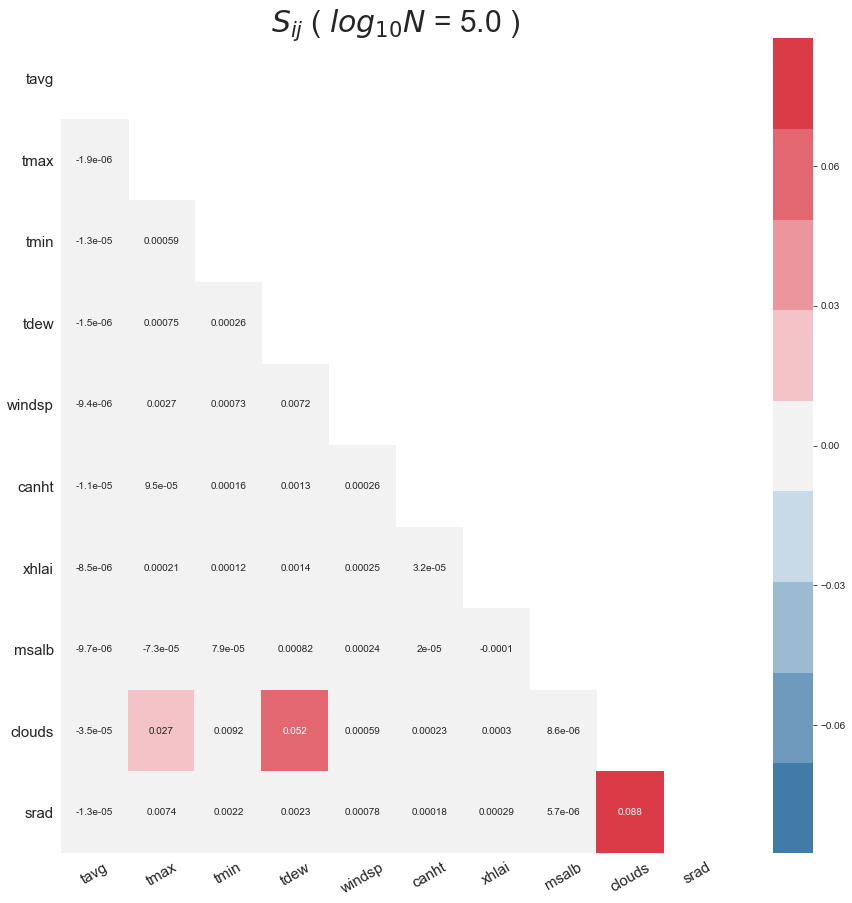

In [30]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

df_PETDYN_S1, df_PETDYN_ST = SM.generate_dataframe()

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## Take Home Message

- SRAD is the most dominant factor in all Penman-Monteith based models. 
- Changes in TMAX or XHLAI do not alter the Ranking of Sensitivity Indices of SRAD.
- Changes in the interval ranges of SRAD can significantly alter the first and second order indices of SRAD as expected. Static code analysis however shows that SRAD do not appear in any conditional statements that will lead to evaulation of the response funciton (EO) in a piecewise manner. In all three cases, SRAD appears in the assignment of RNET and EO shares a linear relationship with RNET and hence SRAD.

```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
      RNETMG = (RNET-G)
      EO=((S*RNETMG + (DAIR*SHAIR*VPD)/RAERO)/(S+PSYCON*(1+RTOT/RAERO)))
```

Tables below with a list of ST (total sensitivity index due to a parameter) and the first order indices (S1) for each model - PETPT, PETPNO, PETPEN, PETDYN have been provided can summarize our results. For the sake of simplicity, TMAX is chosen to lie within the interval : [5.0, 35.0], in all cases.

## 1. ST

In [39]:
from soboltable import table
from IPython.display import display

frames = [df_PETPT_ST, df_PETPNO_ST, df_PETPEN_ST, df_PETDYN_ST]

display(table(frames))

,PETPT,PETPNO,PETPEN,PETDYN
tmax,0.767525,0.228378,0.0437066,0.068693
tmin,0.0119755,0.0684524,0.0155241,0.0227243
xhlai,2.19221e-14,0.000626653,0.0624619,0.0045478
msalb,7.62995e-05,2.76317e-05,0,3.03736e-05
srad,0.371678,0.590935,0.609499,0.841367
tavg,,4.67605e-05,6.81539e-05,6.38459e-05
tdew,,0.141438,0,0.0113534
clouds,,0.0669965,0.0984848,0.0836599
windsp,,0.000222618,3.58337e-05,0.00260643
vapr,,,0.126744,


## 2. S1

In [40]:
frames = [df_PETPT_S1, df_PETPNO_S1, df_PETPEN_S1, df_PETDYN_S1]

display(table(frames))

,PETPT,PETPNO,PETPEN,PETDYN
tmax,0.618715,0.181278,0.0308929,0.0510626
tmin,0.00631634,0.0480315,0.0112735,0.0154786
xhlai,-9.06684e-11,0.000397321,-0.000386185,0.00285375
msalb,4.04222e-05,2.4453e-07,0,1.11259e-05
srad,0.22434,0.529978,0.561257,0.823079
tavg,,3.40238e-05,4.71648e-05,4.81868e-05
tdew,,0.110224,0,0.000244953
clouds,,0.0511545,0.0202504,0.0707099
windsp,,3.87944e-05,1.33137e-05,0.000513104
vapr,,,0.0462347,
